In [9]:
import numpy as np
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth
from obspy import UTCDateTime
from obspy.signal.rotate import rotate2zne
from obspy.core.stream import Stream
from obspy import read,read_inventory
from obspy.signal.cross_correlation import xcorr
from obspy.signal.rotate import rotate_ne_rt
from obspy import Trace, Stream


import matplotlib.pyplot as plt
# import pygmt
font = "11p,Helvetica-Bold"

+ HHZ/HHN/HHE: High Broad Band Seismometer
+ HNZ/HNN/HNE: High Broad Band Accelerometer  
+ EHZ/EHN/EHE: Short Period 100 sps (Extremely Short Period: T>10s)
+ BHZ/BHN/BHE: Broad Band 20 sps
+ LHZ/LHN/LHE: Long Period 1 sps
+ VHZ/VHN/VHE: Very Long Period 0.1 sps

In [83]:
print(waveform)

10 Trace(s) in Stream:
AV.VNKR..EHZ | 2021-07-29T06:15:29.190000Z - 2021-07-29T06:18:49.180000Z | 100.0 Hz, 20000 samples
AV.DOL..BHE  | 2021-07-29T06:15:29.200000Z - 2021-07-29T06:18:49.180000Z | 50.0 Hz, 10000 samples
AV.DOL..BHN  | 2021-07-29T06:15:29.200000Z - 2021-07-29T06:18:49.180000Z | 50.0 Hz, 10000 samples
AV.DOL..BHZ  | 2021-07-29T06:15:29.200000Z - 2021-07-29T06:18:49.180000Z | 50.0 Hz, 10000 samples
AK.S15K..HNE | 2021-07-29T06:15:29.188400Z - 2021-07-29T06:18:49.178400Z | 100.0 Hz, 20000 samples
AK.S15K..HNN | 2021-07-29T06:15:29.188400Z - 2021-07-29T06:18:49.178400Z | 100.0 Hz, 20000 samples
AK.S15K..HNZ | 2021-07-29T06:15:29.188400Z - 2021-07-29T06:18:49.178400Z | 100.0 Hz, 20000 samples
AK.CHN..BHE  | 2021-07-29T06:15:29.188400Z - 2021-07-29T06:18:49.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BHN  | 2021-07-29T06:15:29.188400Z - 2021-07-29T06:18:49.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BHZ  | 2021-07-29T06:15:29.188400Z - 2021-07-29T06:18:49.168400Z | 50.0 Hz, 10000 s

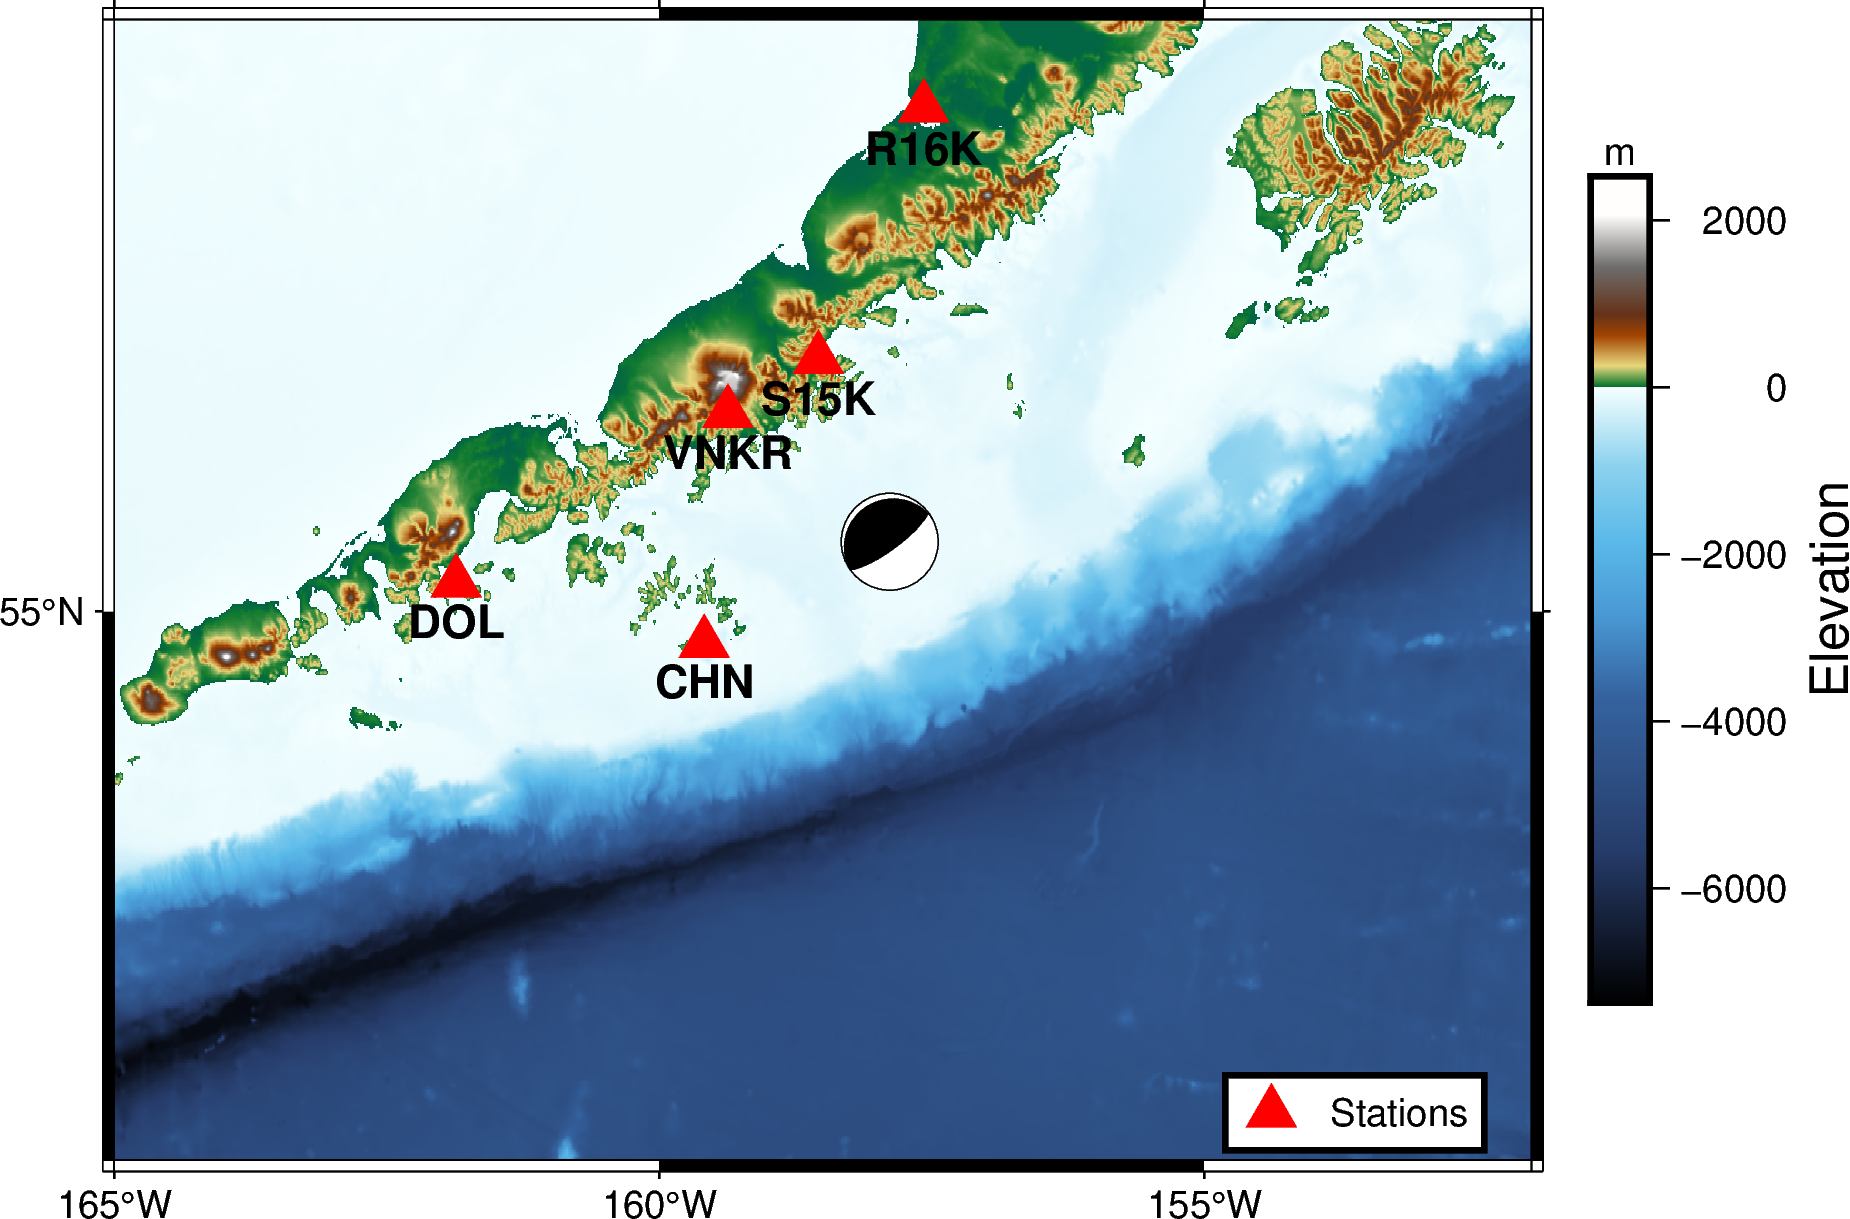

In [154]:
# Focal mechanisms - Alaska M8.2, July 29, 2021  
focal_mechanism = dict(strike=239, dip=14, rake=95, magnitude=8.2)

# Seismic stations 
nw = ['AV','AV','AK','AK','AK']       # network
sta= ['VNKR','DOL','S15K','CHN','R16K']  # station
ch = ['EH*','BH*','HN*','BN*','BH*']      # channel
lon= np.asarray([-159.3699,-161.8638, -158.54, -159.589493,-157.5742])
lat= np.asarray([56.0304, 55.1488, 56.3058, 54.831001,57.5673])

grid = pygmt.datasets.load_earth_relief(resolution="30s", region=[-165,-152,52,58])
fig = pygmt.Figure()
fig.grdimage(grid=grid, projection="M12c", frame="a", cmap='geo')
fig.meca(focal_mechanism, scale="0.5c", longitude=-157.888, latitude=55.364, depth=35.0) # plot focal mechanism
fig.plot(x=lon, y=lat, style="t0.5c", color='red',label='Stations') # plot stations
fig.text(x=lon, y=lat-0.2, text=sta, font=font) # plot station names
fig.legend(position = 'jBR+jMR+o0.4c', box='+gwhite+p1.5p,black')

fig.colorbar(position="JMR+o0.5c/0c+w7c/0.5c+v",frame=["a2000","x+lElevation", "y+lm"]) # position="x12.5c/6.6c+w6c+jTC+v"
fig.show()


In [10]:
cl_iris  = Client("IRIS")
nw = ['AK','AK']       # network
sta= ['CHN','S15K']      # station
ch = ['BN*','HN*']        # channel

# nw = ['AV','AV','AK','AK','AK']       # network
# sta= ['VNKR','DOL','S15K','CHN','R16K']  # station
# ch = ['EHZ','BHZ','HNZ','BHZ','BHZ']      # channel
# Event catalog
cat = cl_iris.get_events(minmagnitude=8.1,maxmagnitude=8.3, starttime=UTCDateTime(2021,7,28),endtime=UTCDateTime(2021,7,30)) # Y
event = cat[0]
print(cat)  

start = event.origins[0].time
end = start + 200

waveform = Stream()

for num in np.arange(len(sta)):
# for num in np.arange(1,2):
    if (num == 0):
        inv = cl_iris.get_stations(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end,level="response")
        inventory  = inv
        st = cl_iris.get_waveforms(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end)
    else:
        inv = cl_iris.get_stations(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end,level="response")
        inventory  += inv
        st = cl_iris.get_waveforms(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end)
    st.remove_response(inventory=inv,output='ACC') 
    st.detrend('simple')
    waveform += st
#     print("Station %f: DONE " %(str(sta[num])))
print(waveform)
        
        

1 Event(s) in Catalog:
2021-07-29T06:15:49.188000Z | +55.364, -157.888 | 8.2 Mww
6 Trace(s) in Stream:
AK.CHN..BNE  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BNN  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BNZ  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.S15K..HNE | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S15K..HNN | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S15K..HNZ | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples


In [16]:
f1 = 0.01
f2 = 0.1
waveform1 = waveform.copy()
waveform1.filter('bandpass',freqmin=f1,freqmax=f2, corners=4, zerophase=True)
# waveform1.plot()

6 Trace(s) in Stream:
AK.CHN..BNE  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BNN  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BNZ  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.S15K..HNE | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S15K..HNN | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S15K..HNZ | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples

In [18]:
sta= ['CHN','S15K']
ch = ['BNE','BNN','BNZ']
waveform_syn = Stream()
for num in range(len(sta)):
    if num < 10:
        filename = 'tp15-receiver-%s.dat'%(sta[num])
#         if num == 0:
        t, vx, vy, vz = np.loadtxt(filename, comments='#', skiprows=2,usecols=(0,7,8,9),unpack=True)
        st = Stream([Trace(vx),Trace(vy),Trace(vz)])    
        for tr_num in range(3):
            st[tr_num].stats['sampling_rate'] = 200
            st[tr_num].stats['network'] = 'SeisSol'
            st[tr_num].stats['station'] = sta[num] 
            st[tr_num].stats['channel'] = ch[tr_num]
        waveform_syn += st
        
f1 = 0.01
f2 = 0.1
waveform_syn1 = waveform_syn.copy()
waveform_syn1.differentiate()
waveform_syn1.filter('bandpass',freqmin=f1,freqmax=f2, corners=4, zerophase=True)

waveform1 = waveform.copy()
waveform1.filter('bandpass',freqmin=f1,freqmax=f2, corners=4, zerophase=True)
            

6 Trace(s) in Stream:
AK.CHN..BNE  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BNN  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BNZ  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.S15K..HNE | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S15K..HNN | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S15K..HNZ | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples

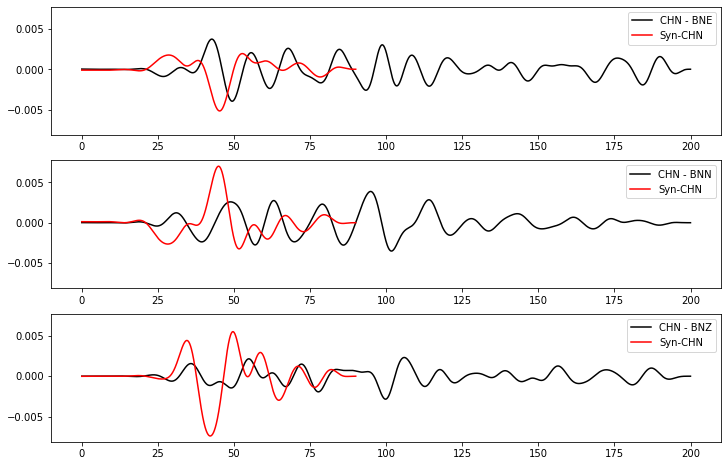

In [27]:
num =0 # Station CHN

plt.figure(figsize=(12, 8))

ax1 = plt.subplot(311)
ax1.plot(waveform1.select(station=sta[num],channel='BNE')[0].times(),waveform1.select(station=sta[num],channel='BNE')[0].data,'k',label='%s - BNE' %(sta[num]))
ax1.plot(waveform_syn1.select(channel='BNE')[0].times(),waveform_syn1.select(channel='BNE')[0].data,'r',label='Syn-%s' %(sta[num]))
ax1.legend()

ax2 = plt.subplot(312,sharey=ax1)
ax2.plot(waveform1.select(station=sta[num],channel='BNN')[0].times(),waveform1.select(station=sta[num],channel='BNN')[0].data,'k',label='%s - BNN' %(sta[num]))
ax2.plot(waveform_syn1.select(channel='BNN')[0].times(),waveform_syn1.select(channel='BNN')[0].data,'r',label='Syn-%s' %(sta[num]))
ax2.legend()

ax3 = plt.subplot(313,sharey=ax1)
ax3.plot(waveform1.select(station=sta[num],channel='BNZ')[0].times(),waveform1.select(station=sta[num],channel='BNZ')[0].data,'k',label='%s - BNZ' %(sta[num]))
ax3.plot(waveform_syn1.select(channel='BNZ')[0].times(),waveform_syn1.select(channel='BNZ')[0].data,'r',label='Syn-%s' %(sta[num]))
ax3.legend()

# ax3.set_xlabel('Time [s]')

plt.show()

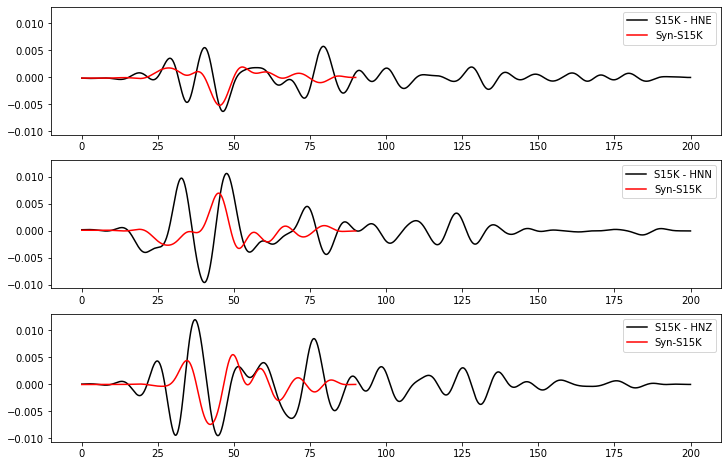

In [26]:
num = 1 # Station S15K

plt.figure(figsize=(12, 8))

ax1 = plt.subplot(311)
ax1.plot(waveform1.select(station=sta[num],channel='HNE')[0].times(),waveform1.select(station=sta[num],channel='HNE')[0].data,'k',label='%s - HNE' %(sta[num]))
ax1.plot(waveform_syn1.select(channel='BNE')[0].times(),waveform_syn1.select(channel='BNE')[0].data,'r',label='Syn-%s' %(sta[num]))
ax1.legend()

ax2 = plt.subplot(312,sharey=ax1)
ax2.plot(waveform1.select(station=sta[num],channel='HNN')[0].times(),waveform1.select(station=sta[num],channel='HNN')[0].data,'k',label='%s - HNN' %(sta[num]))
ax2.plot(waveform_syn1.select(channel='BNN')[0].times(),waveform_syn1.select(channel='BNN')[0].data,'r',label='Syn-%s' %(sta[num]))
ax2.legend()

ax3 = plt.subplot(313,sharey=ax1)
ax3.plot(waveform1.select(station=sta[num],channel='HNZ')[0].times(),waveform1.select(station=sta[num],channel='HNZ')[0].data,'k',label='%s - HNZ' %(sta[num]))
ax3.plot(waveform_syn1.select(channel='BNZ')[0].times(),waveform_syn1.select(channel='BNZ')[0].data,'r',label='Syn-%s' %(sta[num]))
ax3.legend()

# ax3.set_xlabel('Time [s]')

plt.show()